In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-reviews-2021/steam_reviews.csv


In [5]:
file_path = '/kaggle/input/steam-reviews-2021/steam_reviews.csv'

While looking at latest Kaggle competition I found this one that was really interesting and could solve our problem on [how to deal with large dataset](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use ): 

It is sponsored by Dell and Nvidia that suggest the use of their new technology to deal with pandas dataframe with the use of GPU.

More info about the project can be found in their [official page](https://developer.nvidia.com/rapids)

While more info regarding the library we are gonna use can be found on their [github repository](https://github.com/rapidsai/cudf)

In [5]:
import cudf
import rmm

print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())

RAPIDS cuDF is using GPU memory: True


# [RQ5] It is interesting to explore the top reviewers to gain insight into their demographic location, the quality of their reviews, and the applications they tend to review most frequently.



In [ ]:
df_rq5 = cudf.read_csv(file_path, usecols=['author.steamid', 'review_id','language','votes_helpful','app_name'])

### Determine the ten reviewers with the highest number of reviews in the dataset.


In [20]:
df_rq5 = cudf.read_csv(file_path, usecols=['author.steamid', 'review_id','language','votes_helpful','app_name'])
reviewer_counts = df_rq5.groupby('author.steamid').size().reset_index(name='review_count')
top_reviewers = reviewer_counts.sort_values(by='review_count', ascending=False).head(10)

print(top_reviewers)


             author.steamid  review_count
2102182   76561198062813911           149
10063909  76561198315585536           132
7971611   76561198192166873           107
3192200   76561198239163744           106
1250658   76561198045381877           103
3705816   76561198064946151           100
2443283   76561198013146396            99
5238613   76561198027973295            96
2964203   76561197969749884            88
11118453  76561197989746995            86


### What is the percentage of each language used by these top 10 reviewers when submitting a review?


In [13]:
top_reviewer_ids = top_reviewers['author.steamid'].to_arrow().to_pylist()
top_reviews = df_rq5[df_rq5['author.steamid'].isin(top_reviewer_ids)]
language_counts = top_reviews.groupby('language').size().reset_index(name='count')
total_reviews = language_counts['count'].sum()
language_counts['percentage'] = (language_counts['count'] / total_reviews) * 100

print(language_counts)


   language  count  percentage
0  schinese    191   17.917448
1   russian    300   28.142589
2   english    575   53.939962


### Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.


In [15]:
top_reviews = df_rq5[df_rq5['author.steamid'].isin(top_reviewer_ids)][['author.steamid', 'votes_helpful']]
helpful_votes_avg = top_reviews.groupby('author.steamid')['votes_helpful'].mean().reset_index(name='average_helpful_votes')

print(helpful_votes_avg)


      author.steamid  average_helpful_votes
0  76561198062813911               0.885906
1  76561198045381877               2.252427
2  76561198239163744               7.641509
3  76561197989746995              21.058140
4  76561198027973295              11.802083
5  76561198064946151               3.990000
6  76561198192166873              38.897196
7  76561197969749884              26.238636
8  76561198013146396               0.969697
9  76561198315585536              49.712121


### Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.


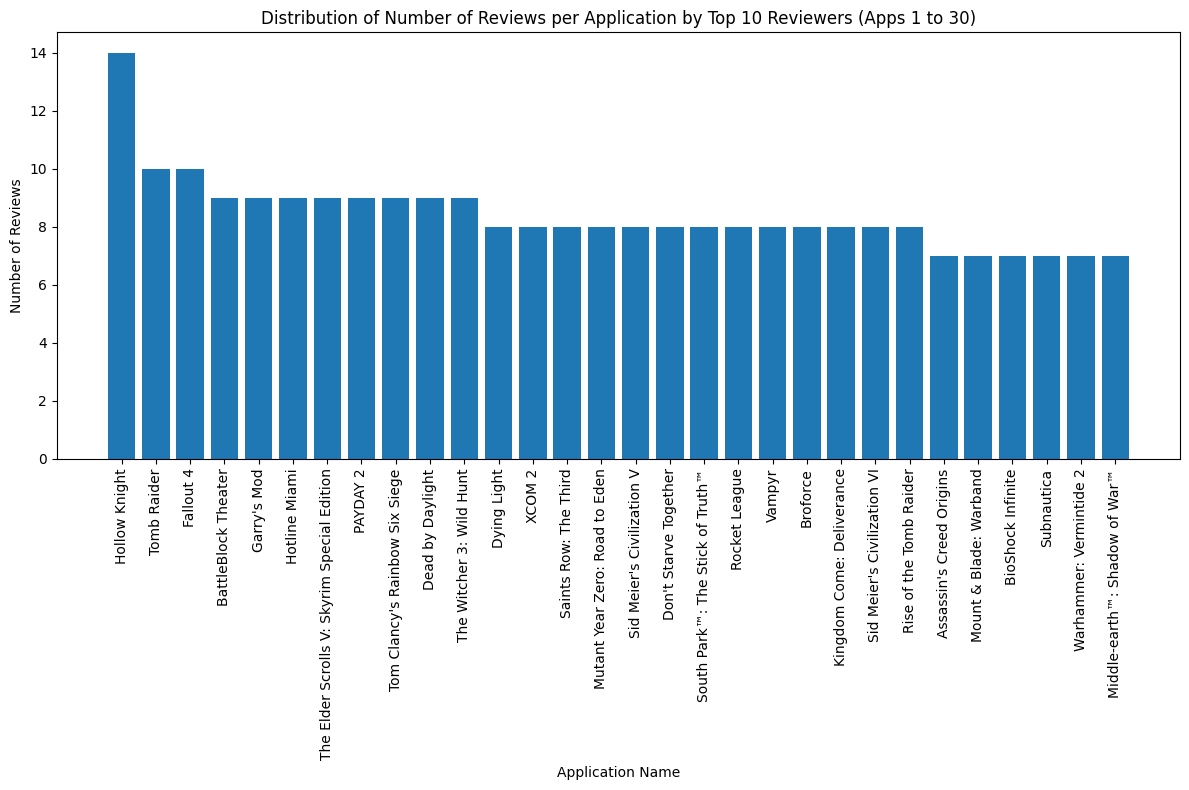

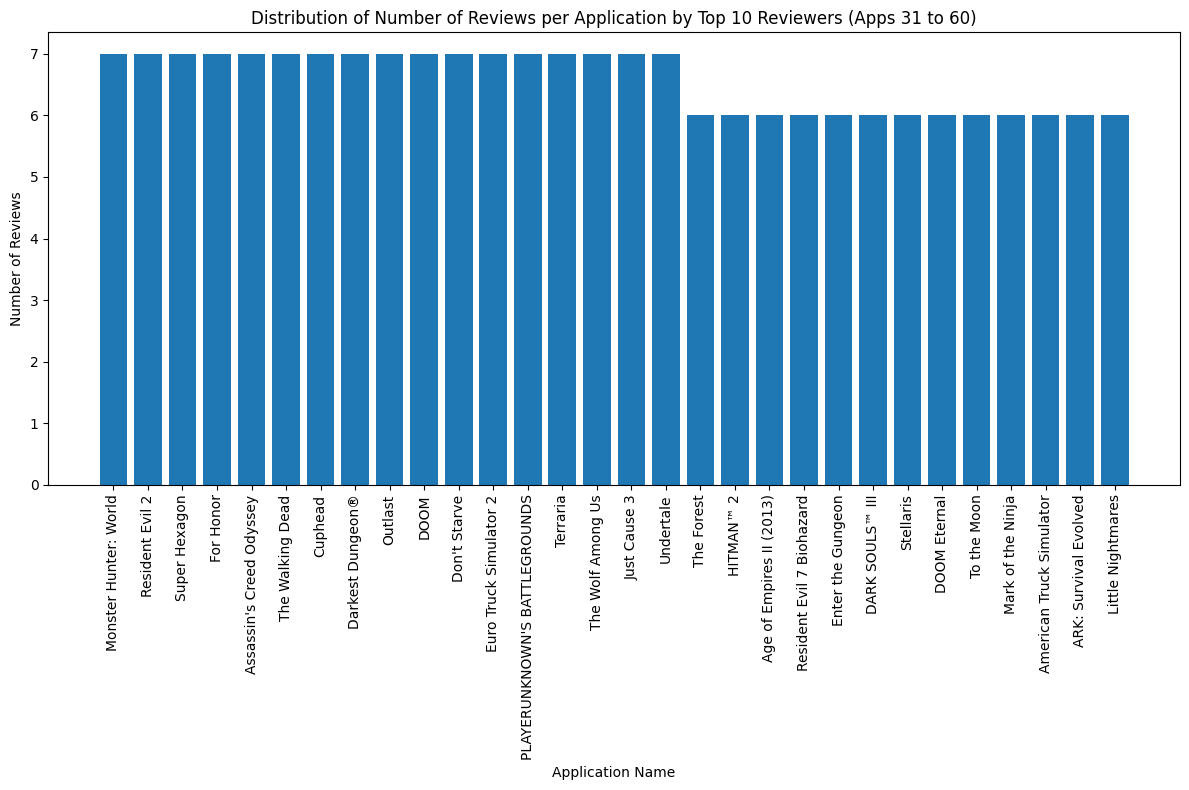

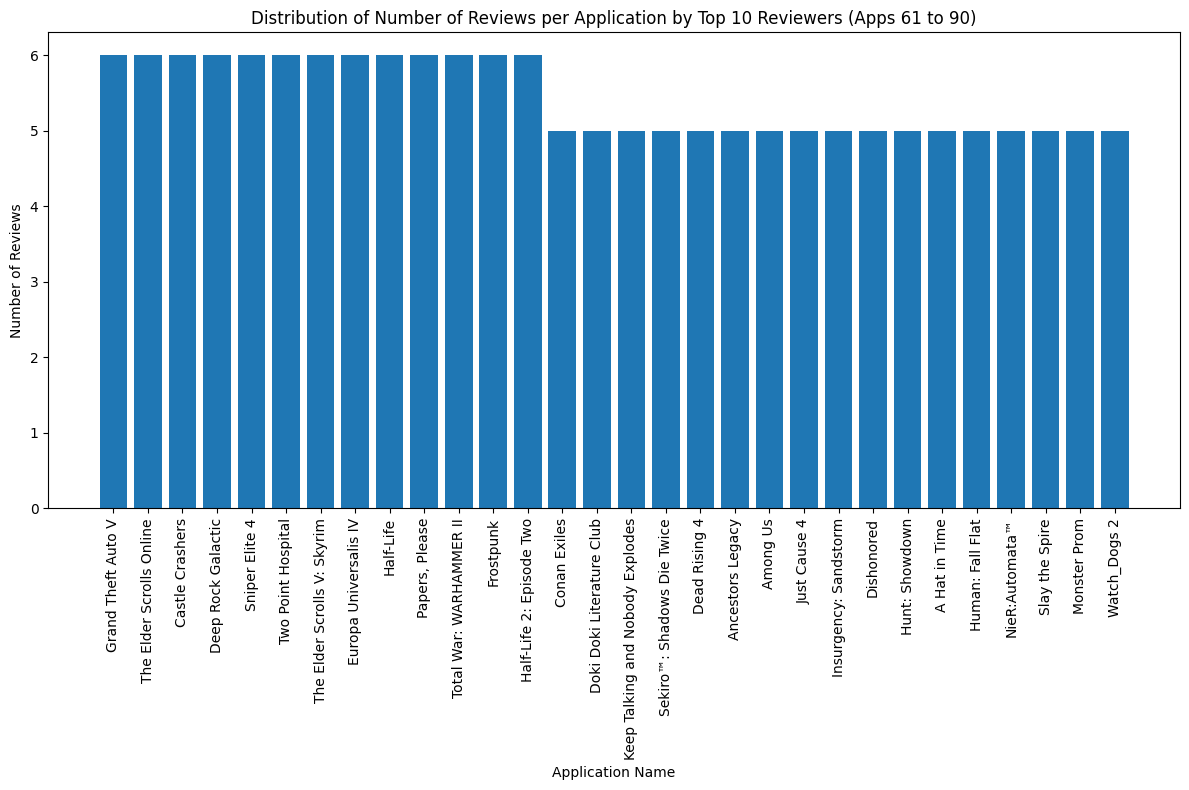

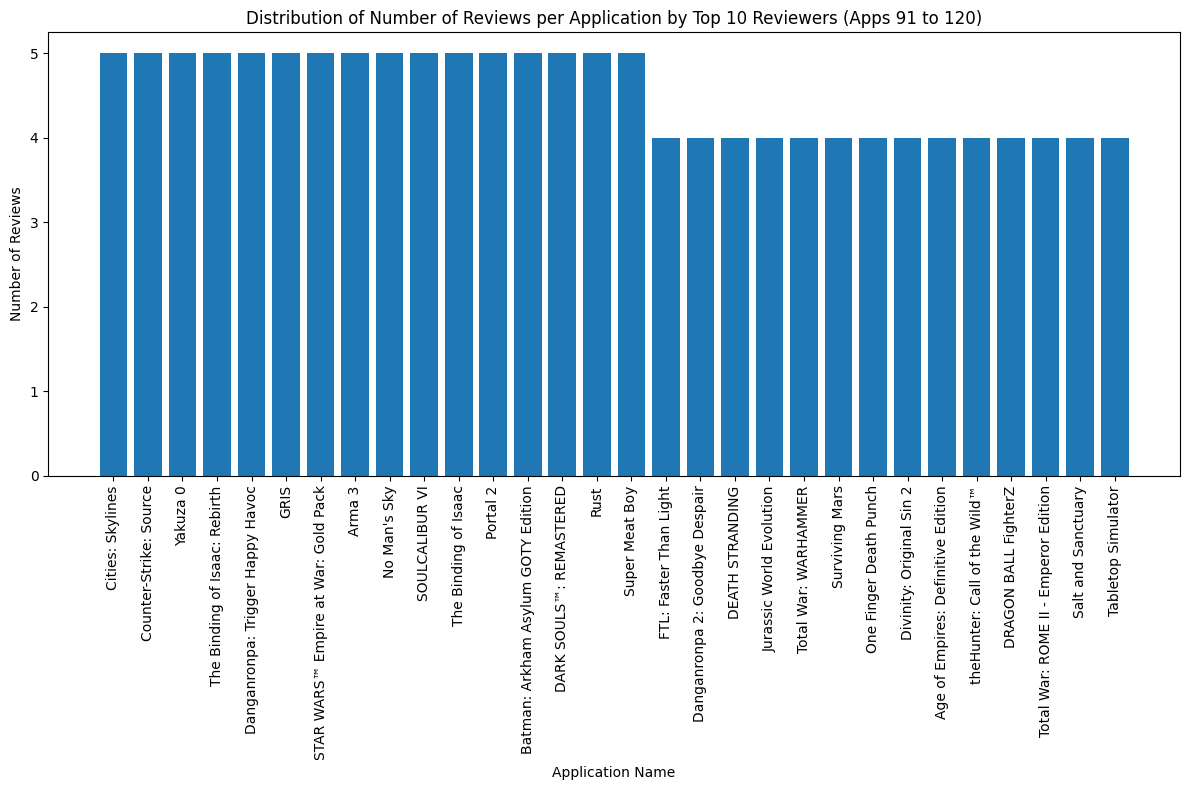

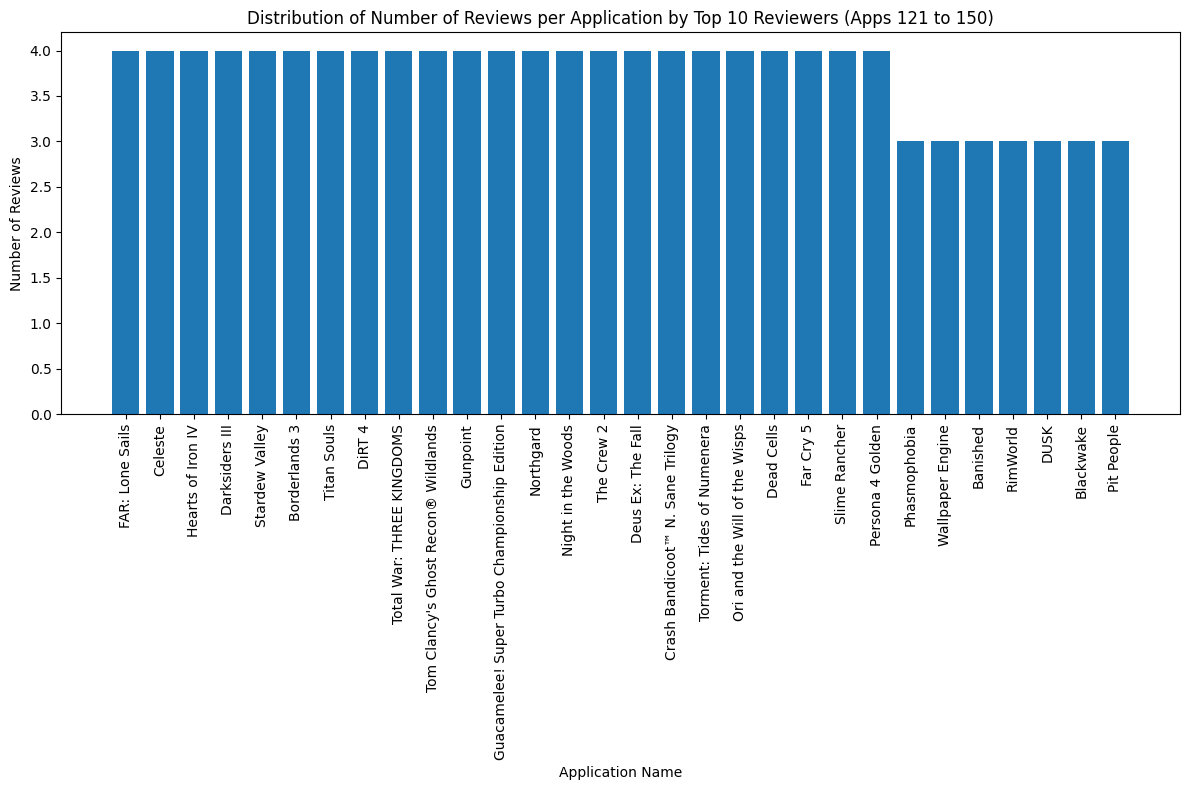

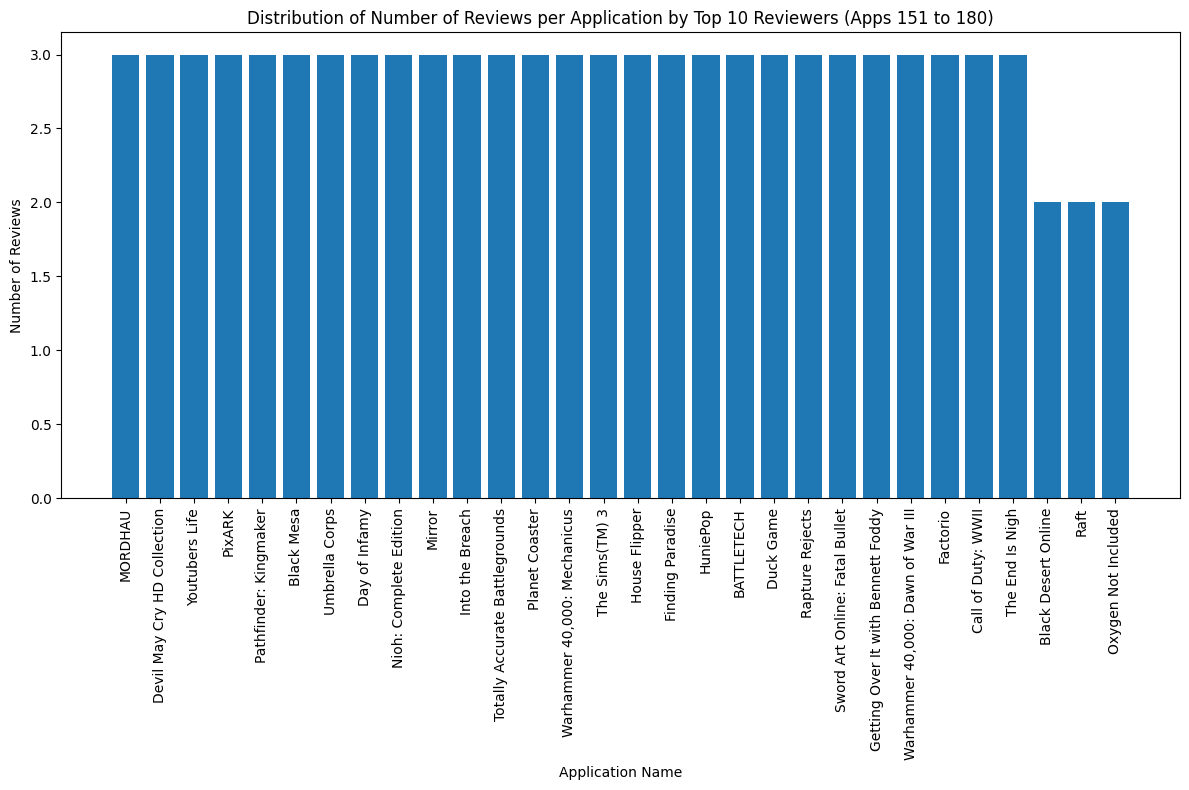

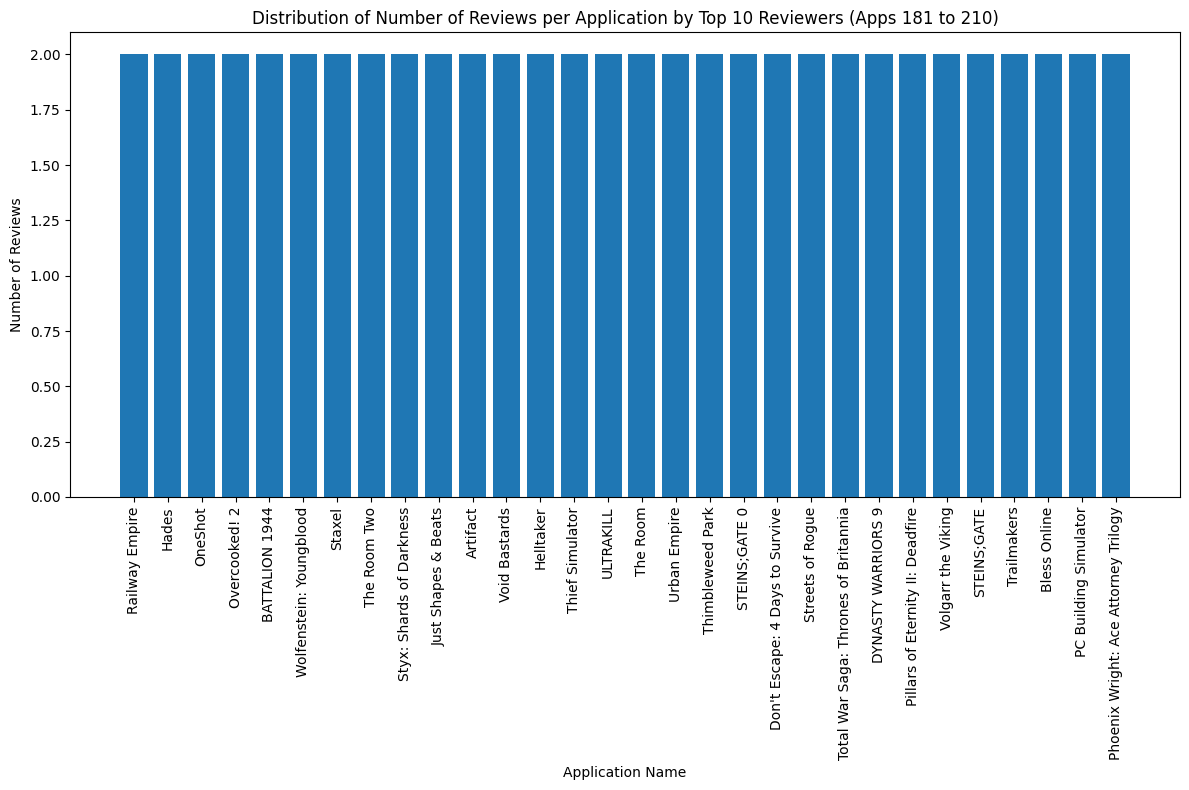

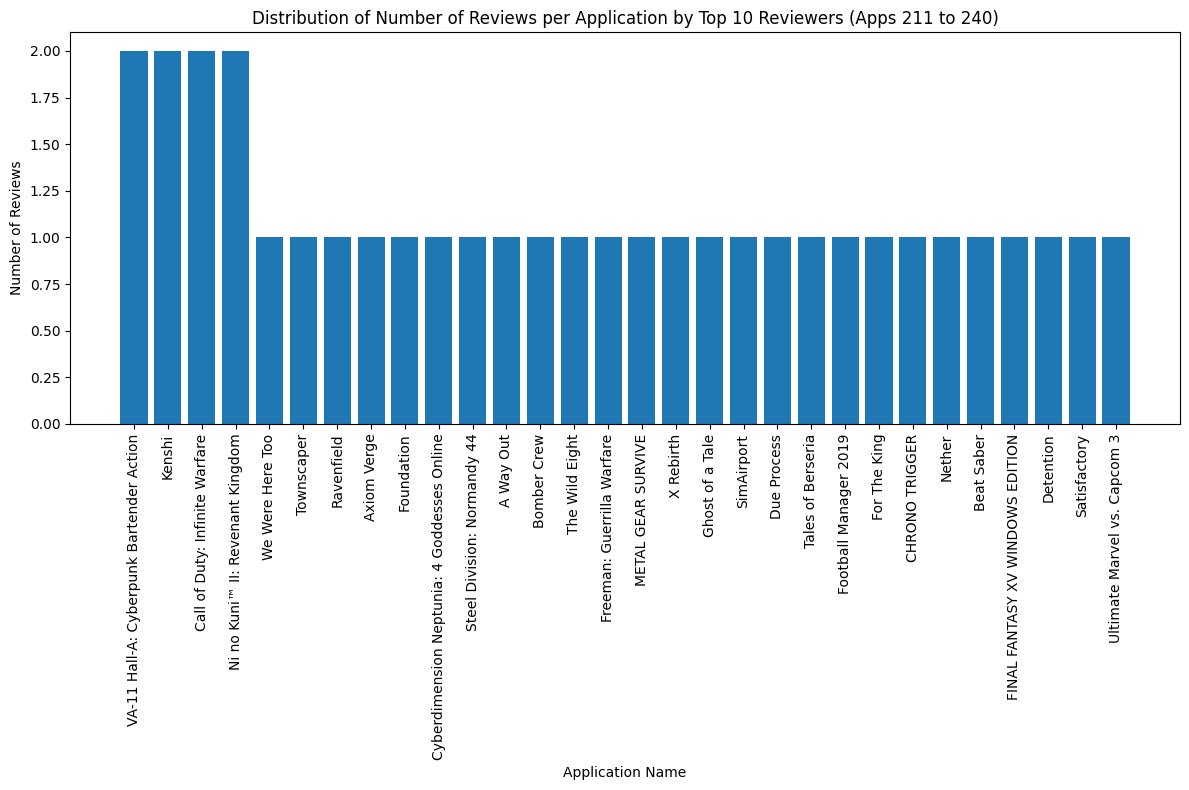

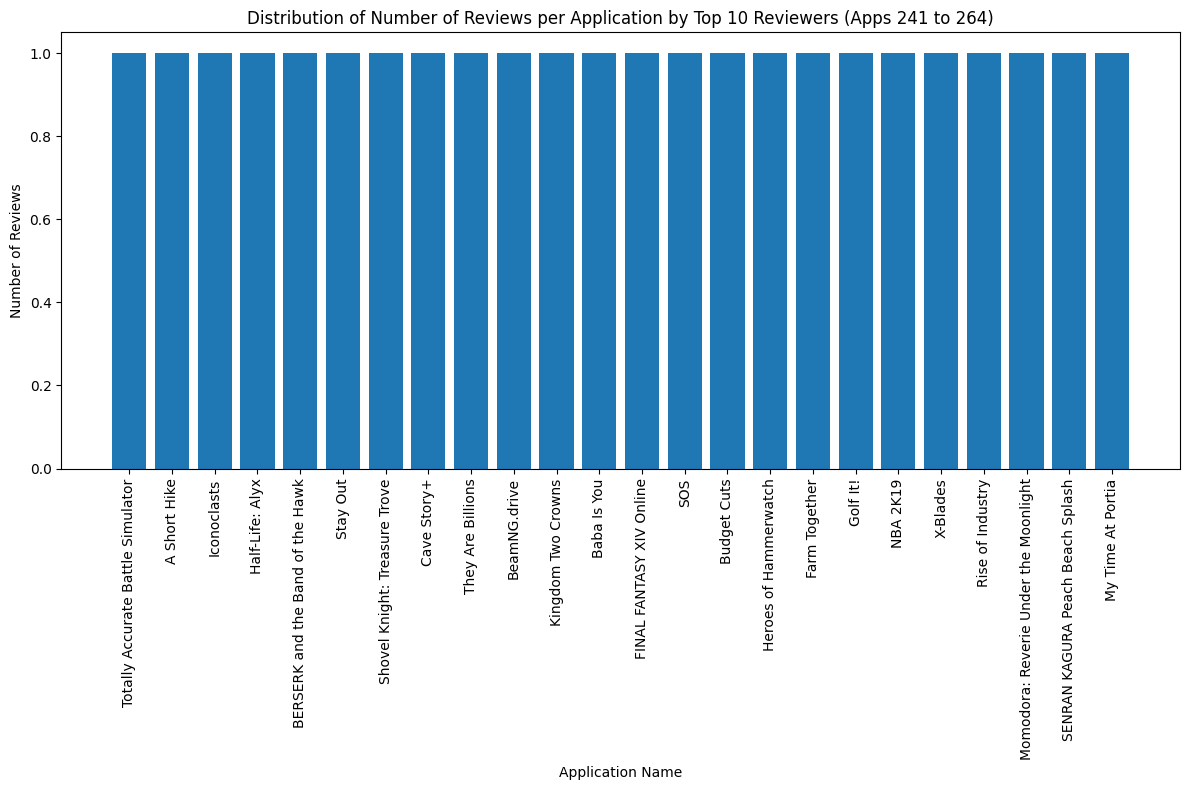

In [27]:
import matplotlib.pyplot as plt
import numpy as np

#we have 315 games, so we have to make more plots to make it readable
apps_per_plot = 30  
num_plots = int(np.ceil(len(app_review_counts) / apps_per_plot))

for i in range(num_plots):
    #range
    start_idx = i * apps_per_plot 
    end_idx = min((i + 1) * apps_per_plot, len(app_review_counts))
    
    # Subset of applications for the current plot
    subset_app_ids = app_review_counts['app_name'].iloc[start_idx:end_idx].to_numpy()
    subset_review_counts = app_review_counts['review_count'].iloc[start_idx:end_idx].to_numpy()
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.bar(subset_app_ids, subset_review_counts)
    plt.xlabel("Application Name")
    plt.ylabel("Number of Reviews")
    plt.title(f"Distribution of Number of Reviews per Application by Top 10 Reviewers (Apps {start_idx+1} to {end_idx})")
    plt.xticks(rotation=90)  
    plt.tight_layout() 
    plt.show()


# [RQ6] Let's investigate the behavior of specific groups, specifically focusing on English and Spanish reviewers


In [29]:
df_rq6 = cudf.read_csv(file_path, usecols=['language', 'timestamp_created', 'timestamp_updated', 'author.num_games_owned', 'author.num_reviews'])

### Which group is more likely to edit or update their review after submitting it? “English or Spanish!”?


In [30]:
english_reviews = df_rq6[df_rq6['language'] == 'english']
spanish_reviews = df_rq6[df_rq6['language'] == 'spanish']
#total rev
total_english_reviews = english_reviews.shape[0]
total_spanish_reviews = spanish_reviews.shape[0]

# updated rev 
english_updated = english_reviews[english_reviews['timestamp_updated'] != english_reviews['timestamp_created']].shape[0]
spanish_updated = spanish_reviews[spanish_reviews['timestamp_updated'] != spanish_reviews['timestamp_created']].shape[0]

# Proportion
english_update_proportion = english_updated / total_english_reviews if total_english_reviews > 0 else 0
spanish_update_proportion = spanish_updated / total_spanish_reviews if total_spanish_reviews > 0 else 0

print("Proportion of updated reviews:")
print(f"English: {english_update_proportion:.2%}")
print(f"Spanish: {spanish_update_proportion:.2%}")

Proportion of updated reviews:
English: 11.89%
Spanish: 9.94%
English reviewers are more likely to update their reviews.


English reviewers are more likely to update their reviews

### Provide the average number of games that reviewers from each group have on their Steam accounts and the average number of games for which they write reviews. What can you say about the number you just calculated?


In [31]:
# game owned
english_avg_games_owned = english_reviews['author.num_games_owned'].mean()
spanish_avg_games_owned = spanish_reviews['author.num_games_owned'].mean()

print("Average number of games owned by reviewers:")
print(f"English: {english_avg_games_owned:.2f}")
print(f"Spanish: {spanish_avg_games_owned:.2f}")

# game reviewed
english_avg_reviews_written = english_reviews['author.num_reviews'].mean()
spanish_avg_reviews_written = spanish_reviews['author.num_reviews'].mean()

print("\nAverage number of games for which they write reviews:")
print(f"English: {english_avg_reviews_written:.2f}")
print(f"Spanish: {spanish_avg_reviews_written:.2f}")

Average number of games owned by reviewers:
English: 1369501.6635062841
Spanish: 121.91626051246742

Average number of games for which they write reviews:
English: 456456.8744984789
Spanish: 9.387421924949589

Interpretation of the number of games owned and reviewed:
English reviewers tend to own more games on average than Spanish reviewers.
English reviewers also tend to review more games on average than Spanish reviewers.


English reviewers tend to own more games on average than Spanish reviewers.

English reviewers also tend to review more games on average than Spanish reviewers.


# [RQ7] Certainly, calculating probabilities and conducting statistical tests are essential skills for any data scientist. Let's calculate some intriguing figures.



In [32]:
df_rq7 = cudf.read_csv(file_path, usecols=['votes_helpful', 'recommended', 'author.num_reviews', 'author.num_games_owned'])

### What is the probability of submitting a review and receiving at least one helpful vote from other users?


In [33]:
total_reviews = df_rq7.shape[0]
reviews_with_helpful_votes = df_rq7[df_rq7['votes_helpful'] > 0].shape[0]
prob_helpful_vote = reviews_with_helpful_votes / total_reviews if total_reviews > 0 else 0

print(f"Probability of receiving at least one helpful vote: {prob_helpful_vote:.2%}")


Probability of receiving at least one helpful vote: 28.07%


### What is the probability of submitting a review and receiving at least one helpful vote from other users, given that you don’t recommend the app?


In [34]:
non_recommended_reviews = df_rq7[df_rq7['recommended'] == False]
total_non_recommended = non_recommended_reviews.shape[0]
non_recommended_helpful_votes = non_recommended_reviews[non_recommended_reviews['votes_helpful'] > 0].shape[0]

# Conditional Probability
prob_helpful_given_non_recommend = non_recommended_helpful_votes / total_non_recommended if total_non_recommended > 0 else 0
print(f"Probability of receiving at least one helpful vote given a non-recommendation: {prob_helpful_given_non_recommend:.2%}")

Probability of receiving at least one helpful vote given a non-recommendation: 48.46%


### Is the probability of “a review receiving at least one helpful vote” independent of the probability that “the reviewer has submitted at least five reviews before the current review”? Elaborate on it.


In [36]:
# Probability of receiving at least one helpful vote
P_A = prob_helpful_vote #RQ7.1

# Probability that the reviewer has submitted at least 5 reviews
total_five_reviews = df_rq7[df_rq7['author.num_reviews'] >= 5].shape[0]
P_B = total_five_reviews / total_reviews if total_reviews > 0 else 0

# Probability of both events occurring
reviews_with_helpful_and_five = df_rq7[(df_rq7['votes_helpful'] > 0) & (df_rq7['author.num_reviews'] >= 5)].shape[0]
P_A_and_B = reviews_with_helpful_and_five / total_reviews if total_reviews > 0 else 0

# Independence
independent = P_A_and_B == (P_A * P_B)
print(f"P(A): {P_A:.4f}")
print(f"P(B): {P_B:.4f}")
print(f"P(A ∩ B): {P_A_and_B:.4f}")
print(f"Are 'receiving at least one helpful vote' and 'reviewer has submitted at least 5 reviews' independent? {'Yes' if independent else 'No'}")


P(A): 0.2807
P(B): 0.4555
P(A ∩ B): 0.1564
Are 'receiving at least one helpful vote' and 'having submitted at least five reviews' independent? No


### We hypothesize that “reviewers who own a larger number of games are likely to leave fewer reviews on the platform.” Please validate or refute this statement through statistical analysis.


In [6]:
import cudf
df_rq7_4_cudf = cudf.read_csv(file_path, usecols=['author.num_games_owned', 'author.num_reviews'])
df_rq7_4 = df_rq7_4_cudf.to_pandas()


##### Pearson's correlation


In [7]:
from scipy.stats import pearsonr

pearson_corr, pearson_p_value = pearsonr(df_rq7_4['author.num_games_owned'], df_rq7_4['author.num_reviews'])

# Display results for Pearson's correlation
print(f"Pearson's correlation coefficient: {pearson_corr:.2f}")
print(f"P-value for Pearson's correlation: {pearson_p_value:.2e}")

Pearson's correlation coefficient: -0.00
P-value for Pearson's correlation: 9.99e-01


no linear relationship

##### Spearman's rank correlation


In [8]:
from scipy.stats import spearmanr

spearman_corr, spearman_p_value = spearmanr(df_rq7_4['author.num_games_owned'], df_rq7_4['author.num_reviews'])

print(f"Spearman's correlation coefficient: {spearman_corr:.2f}")
print(f"P-value for Spearman's correlation: {spearman_p_value:.2e}")


Spearman's correlation coefficient: 0.60
P-value for Spearman's correlation: 0.00e+00


As the number of games owned increases, the tendency to submit reviews also increases, contradicting the hypothesis. This result shows that there’s a non-linear relationship, which Pearson’s test couldn’t capture

In [14]:
from scipy.stats import skew, kurtosis

skew_games = skew(df_rq7_4['author.num_games_owned'])
kurt_games = kurtosis(df_rq7_4['author.num_games_owned'])
print(f"skewness 'author.num_games_owned': {skew_games:.2f}")
print(f"kurtosis 'author.num_games_owned': {kurt_games:.2f}")

skew_reviews = skew(df_rq7_4['author.num_reviews'])
kurt_reviews = kurtosis(df_rq7_4['author.num_reviews'])
print(f"skewness 'author.num_reviews': {skew_reviews:.2f}")
print(f"kurtosis 'author.num_reviews': {kurt_reviews:.2f}")


skewness 'author.num_games_owned': 2085.54
kurtosis 'author.num_games_owned': 4349469.20
skewness 'author.num_reviews': 3297.53
kurtosis 'author.num_reviews': 10873680.50


Both distributions are highly skewed.

The high value of kurtosis suggests a leptokurtic distribution (extreme peaks and very long tails)
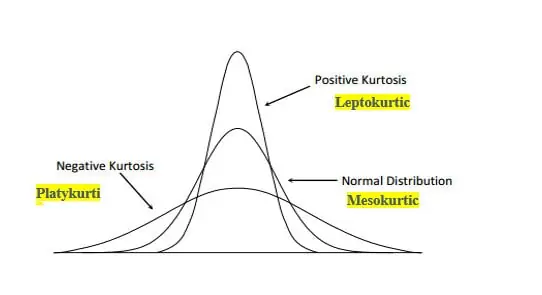

These values ​​indicate a distribution very far from normal, probably with a large number of data concentrated in the vicinity of a few values, with the presence of extreme values ​​or outliers.


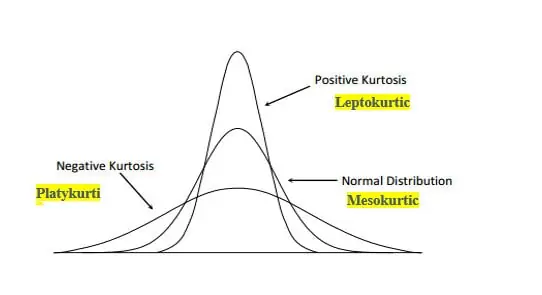
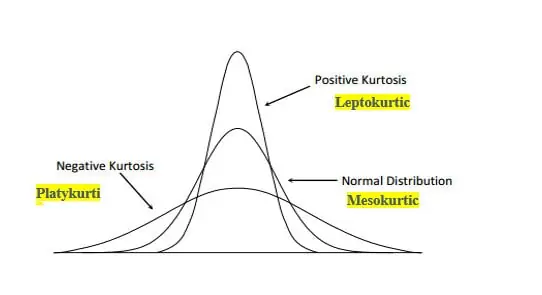
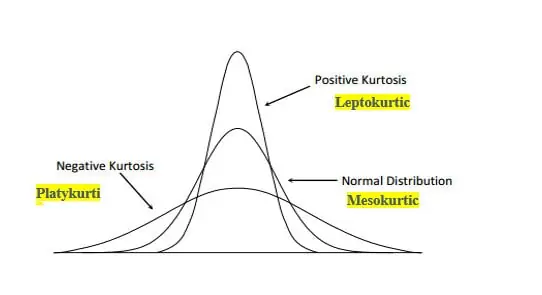

Before going forward, let's just see how the scatterplot of our data points looks like

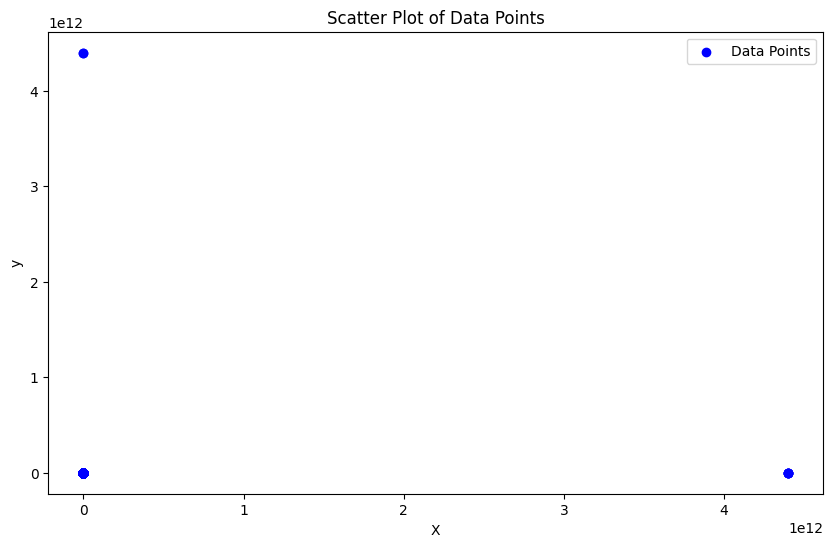

In [30]:
X = df_rq7_4['author.num_games_owned'].values.reshape(-1, 1)
y = df_rq7_4['author.num_reviews'].values

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Scatter Plot of Data Points")
plt.legend()
plt.show()

there is a clear presence of outlier, let's dive deeper: 

In [22]:
print("\nTop 10 'author.num_games_owned':")
print(df_rq7_4['author.num_games_owned'].nlargest(10))

print("\nTop 10 'author.num_reviews':")
print(df_rq7_4['author.num_reviews'].nlargest(10))


Top 10 'author.num_games_owned':
5502449     4398046511619
21079021    4398046511316
3507697     4398046511179
8680945     4398046511170
6913009     4398046511151
5790335             24258
5242234             24184
4418318             24172
17742447            22024
20632981            22023
Name: author.num_games_owned, dtype: int64

Top 10 'author.num_reviews':
13093694    4398046511108
5663041     4398046511105
504382               5236
575674               5236
656318               5236
1258197              5236
3249032              5236
3274520              5236
3294251              5236
7839830              5236
Name: author.num_reviews, dtype: int64


those values are complitely out of bound

In [26]:
df_filtered = df_rq7_4[(df_rq7_4['author.num_games_owned'] <= 100000) & (df_rq7_4['author.num_reviews'] <= 100000)]
df_filtered['games_owned_decile'] = pd.qcut(df_filtered['author.num_games_owned'], 10)

/tmp/ipykernel_30/3886059253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['games_owned_decile'] = pd.qcut(df_filtered['author.num_games_owned'], 10)


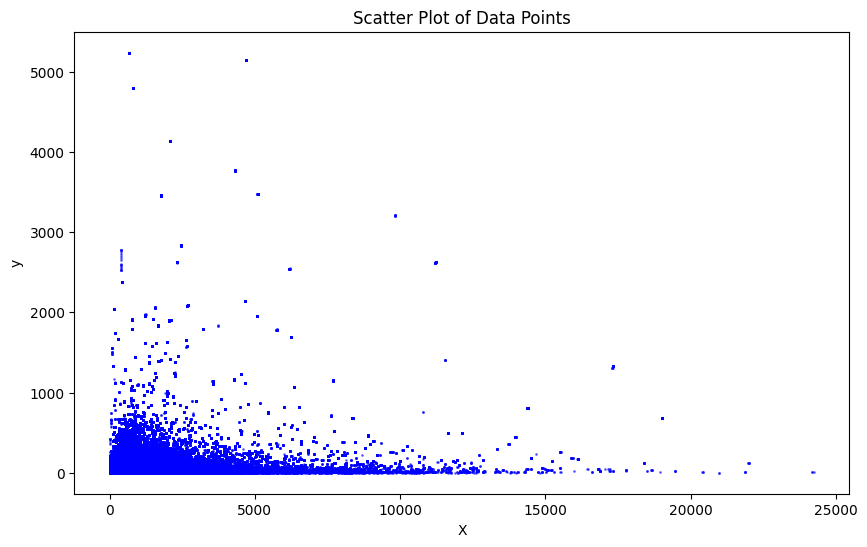

In [32]:
X = df_filtered['author.num_games_owned'].values.reshape(-1, 1)
y = df_filtered['author.num_reviews'].values

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points', s=1, alpha=0.5) # Smaller marker size and transparency
plt.xlabel("X")
plt.ylabel("y")
plt.title("Scatter Plot of Data Points")
#plt.legend() # UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
plt.show()

I see an inversed relationship that looks like an hyperbole, but it's not really clear

In [27]:
from scipy.stats import kruskal
#Distribution Shift Analysis Using Kruskal-Wallis Test
groups = [group['author.num_reviews'].values for name, group in df_filtered.groupby('games_owned_decile')]

kruskal_stat, kruskal_p = kruskal(*groups)
print(f"Kruskal-Wallis test for groups in 'author.num_games_owned': Stats={kruskal_stat:.2f}, P-value={kruskal_p:.2e}")


/tmp/ipykernel_30/854629439.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['author.num_reviews'].values for name, group in df_filtered.groupby('games_owned_decile')]


Kruskal-Wallis test for groups in 'author.num_games_owned': Stats=7735639.53, P-value=0.00e+00


The significant result indicates that the number of reviews varies depending on the range of games owned. However, it does not indicate the direction of the relationship (whether reviewers with more games tend to leave more or fewer reviews) or which ranges exhibit specific differences.

In [28]:
median_reviews_by_decile = df_filtered.groupby('games_owned_decile')['author.num_reviews'].median()
print("Median for each decile of 'author.num_games_owned':\n", median_reviews_by_decile)


/tmp/ipykernel_30/2426924743.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_reviews_by_decile = df_filtered.groupby('games_owned_decile')['author.num_reviews'].median()


Mediane delle recensioni per decile di 'author.num_games_owned':
 games_owned_decile
(-0.001, 7.0]        1.0
(7.0, 17.0]          2.0
(17.0, 28.0]         2.0
(28.0, 42.0]         3.0
(42.0, 61.0]         4.0
(61.0, 85.0]         5.0
(85.0, 121.0]        6.0
(121.0, 178.0]       7.0
(178.0, 301.0]       9.0
(301.0, 24258.0]    15.0
Name: author.num_reviews, dtype: float64



000
From the median number of reviews for each decile of game ownership, we see a clear progressive increase in the average number of reviews as the number of games owned increases. This result refutes the hypothesis that "reviewers who own more games are likely to leave fewer reviews."

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


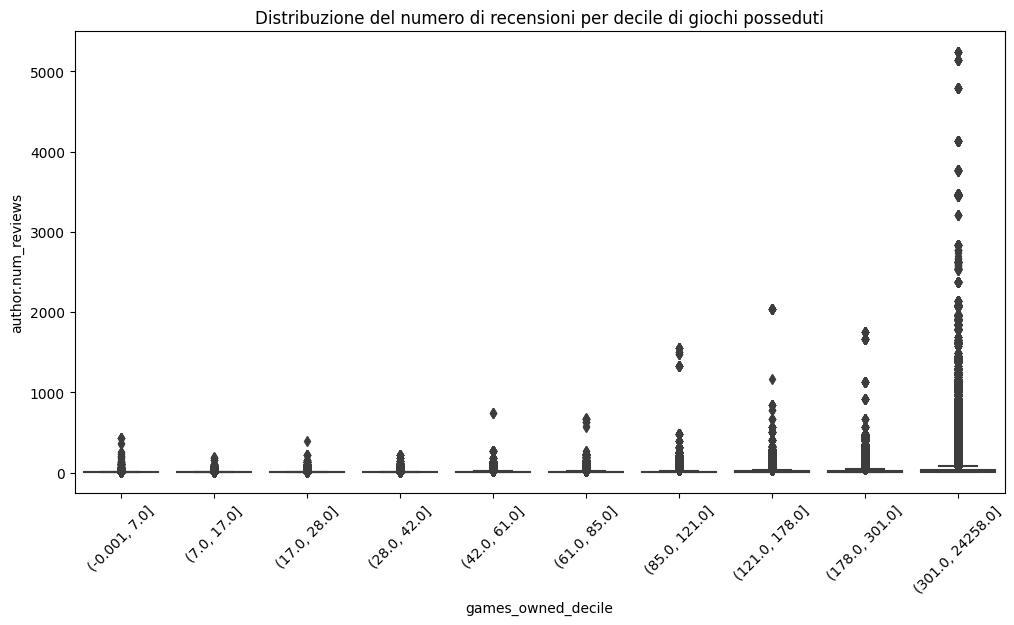

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='games_owned_decile', y='author.num_reviews', data=df_filtered)
plt.xticks(rotation=45)
plt.title("Distribuzione del numero di recensioni per decile di giochi posseduti")
plt.show()


The plot suggests that there may be distinct subgroups among those who own a lot of games: some active reviewers and some less active.

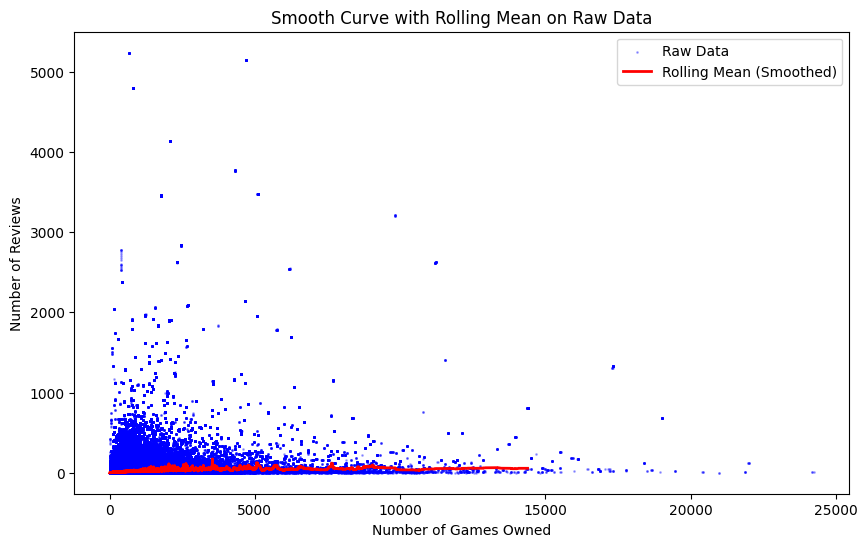

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_filtered 
df_sorted = df.sort_values(by='author.num_games_owned')

#rolling median
df_sorted['smoothed_reviews'] = df_sorted['author.num_reviews'].rolling(window=500, center=True).median()
# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['author.num_games_owned'], df_sorted['author.num_reviews'], s=1, color='blue', alpha=0.3, label='Raw Data')
plt.plot(df_sorted['author.num_games_owned'], df_sorted['smoothed_reviews'], color='red', linewidth=2, label='Rolling Mean (Smoothed)')
plt.xlabel('Number of Games Owned')
plt.ylabel('Number of Reviews')
plt.title('Smooth Curve with Rolling Mean on Raw Data')
plt.legend()
plt.show()


The use of the median over the mean shows a much smoother trend and doesn't need to deal with outliers since it's a more robust method. 

Users with very few games (e.g., close to 0) seem slightly less active in terms of reviews, but since the trend is not really clear (the slope is so small that it can't be really understood), we can't say that the number of games owned influence review activity for the majority of users.




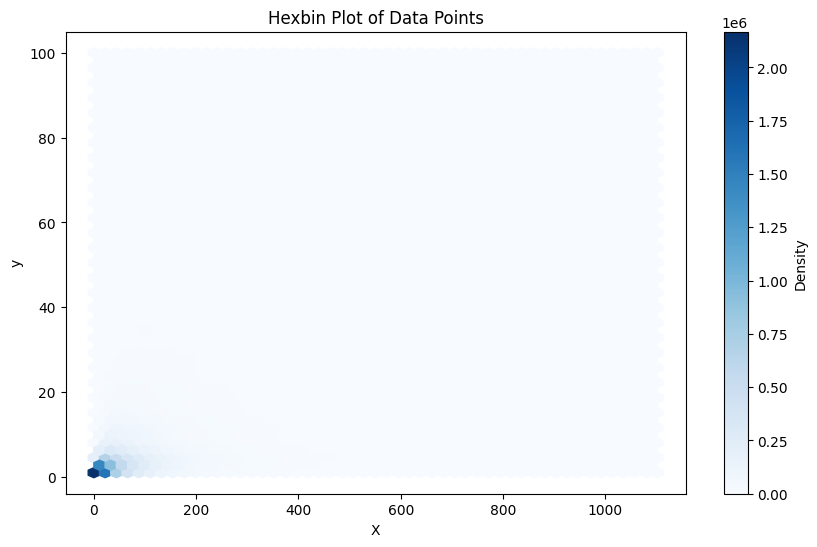

In [16]:
# Hexbin plot to show density of our data points
plt.figure(figsize=(10, 6))
plt.hexbin(X.flatten(), y.flatten(), gridsize=50, cmap='Blues') 
plt.xlabel("X")
plt.ylabel("y")
plt.title("Hexbin Plot of Data Points")
plt.colorbar(label='Density')
plt.show()

Since there is this high density of value near to 0, I don't consider the use of logaritmic transformation

Just out of curiosity, since the previous test denied any linear relationship but suggested that a non-linear relationship may occur, we try to fit a 2nd degree polynomial

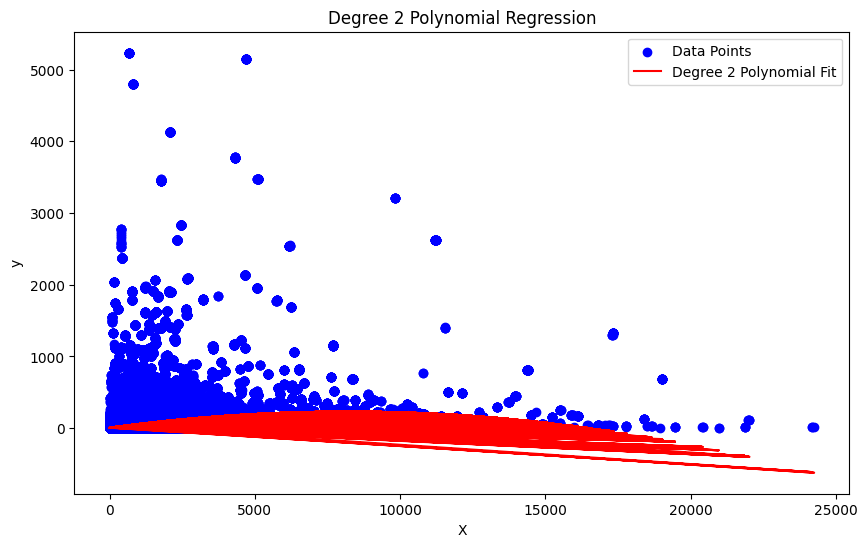

R² for polynomial degree 2: 0.12
RMSE for polynomial degree 2: 32.06


In [46]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit 
model = LinearRegression()
model.fit(X_poly, y)

# Predict 
y_pred = model.predict(X_poly)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points')
plt.plot(X, y_pred, color='red', label='Degree 2 Polynomial Fit')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Degree 2 Polynomial Regression")
plt.legend()
plt.show()

print(f"R² for polynomial degree 2: {r2:.2f}")
print(f"RMSE for polynomial degree 2: {rmse:.2f}")

the model doesn’t capture much of the underlying relationship between the variables, but is interesting to see that it confirm what told earlier about the slight initial rise, followed by a very gradual decrease

### Conclusion

To answer the question of the problem, as claimed before, the results refutes the hypothesis that "reviewers who own more games are likely to leave fewer reviews."

I wanted to have a full overview of the relationship between this two features to give a more clear answer supported by the previous statistical analysis. 

In the end the outliers are the biggest problem we had to deal with; when dealing with real data is a problem that often occurs but we can't afford to lose this information  

The central tendency (typical behavior of the majority of the users) shows a slight relationship between games owned and reviews, meaning that for most users, owning more games impact slightly positively their review activity.

The outliers might represent a unique segment of users who behave differently from the average user. Probably they are spammer or gain something to submit more review as possible: while their behavior is interesting, it does not generalize to the broader user base.



Additionally, with more computational resources, it would have been interesting to use LOESS (Local Polynomial Regression) to analyze complex relationship like this one with a method not affected too much by the noise and density. It fits a smooth curve to the data by locally fitting polynomial regressions at various points, showing a trend

### Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to understand the purposes of histograms, bar plots, scatterplots, and pie charts and what kind of insights they offer that might be useful for statistical analysis. Are those results trustworthy, or can you do something to improve somehow the confidence in the suggestions given by the LLM?


## Using LLMs to Understand the Purposes and Insights of Common Charts

When using an LLM tool (such as ChatGPT, Claude AI, Gemini, or Perplexity) to understand the purposes and insights provided by different types of charts like histograms, bar plots, scatterplots, and pie charts, here’s how you might approach evaluating the results and improving confidence in the suggestions:

### 1. Understanding the Purposes and Insights of Common Charts

Let’s start by summarizing what you might expect the LLM to provide as a response for each type of chart:

- **Histograms**:
  - **Purpose**: To show the distribution of a single continuous variable.
  - **Insights**: Can reveal patterns such as skewness, central tendency, spread, and the presence of outliers. Useful for understanding the shape of the data distribution and identifying ranges with high or low frequencies.
  - **Applications in Analysis**: Often used in data cleaning, normality checking, and understanding the distribution of a variable before further statistical modeling.

- **Bar Plots**:
  - **Purpose**: To compare categorical data or discrete quantities.
  - **Insights**: Shows differences in frequency or count across categories, making it easy to compare sizes of different groups.
  - **Applications in Analysis**: Useful for visualizing categorical data, proportions, and even summarizing aggregated values (like means or medians) for different groups.

- **Scatterplots**:
  - **Purpose**: To show the relationship between two continuous variables.
  - **Insights**: Can reveal correlations, clusters, trends, and patterns of association. Useful for understanding potential linear or non-linear relationships between variables.
  - **Applications in Analysis**: Frequently used in regression analysis, identifying outliers, and assessing relationships for further modeling.

- **Pie Charts**:
  - **Purpose**: To show proportions of categories as parts of a whole.
  - **Insights**: Provides a high-level view of the composition of a dataset in terms of relative sizes of categories.
  - **Applications in Analysis**: Generally used in business or presentations, but has limited statistical rigor. Not ideal for datasets with many categories or close values.

### 2. Evaluating the Trustworthiness of LLM Responses

The response from an LLM tool, like the one above, might be generally accurate and reliable, especially if it aligns with statistical knowledge. However, to improve confidence in the suggestions and ensure the information is trustworthy, here are some steps you can take:

1. **Cross-Check with Reputable Sources**:
   - Verify the insights provided by the LLM against reputable resources, such as textbooks on data visualization (e.g., "The Grammar of Graphics" by Leland Wilkinson), statistical guides, or respected online tutorials like those from **Khan Academy** or **Coursera**.
   - Cross-reference with statistical documentation and research to confirm the validity of the claims.

2. **Consult Domain-Specific Experts**:
   - If your analysis is specific to a particular field (e.g., medical, finance, social sciences), consult domain experts who might provide additional context or nuances that the LLM may overlook.
   - Experts can offer insights into common pitfalls and best practices that go beyond the general descriptions of chart purposes.

3. **Experiment and Validate with Data**:
   - Test each visualization type on your dataset to see if it provides the insights the LLM described. For example, create histograms, bar plots, scatterplots, and pie charts, and check if the patterns and insights match the LLM’s explanation.
   - Analyzing real data with these charts will help confirm whether the chart provides meaningful insights and if the LLM’s suggestions hold up in practice.

4. **Look for Consistency in LLM Responses**:
   - Rephrase your question and ask the LLM multiple times. Consistent answers across variations of the question can help increase confidence in the reliability of the response.
   - Additionally, compare answers across different LLMs (e.g., ChatGPT, Claude AI) to see if multiple tools provide similar explanations.

5. **Use Peer-Reviewed Articles and Technical Guides**:
   - Research peer-reviewed articles or technical guides on visualization techniques. These often contain comparisons of visualization effectiveness and reliability for different types of data and insights.
   - You can use resources like **IEEE Xplore**, **PubMed**, or **Google Scholar** to find literature on the effectiveness of histograms, bar plots, scatterplots, and pie charts in statistical analysis.

6. **Be Aware of Limitations in LLM Training Data**:
   - Recognize that LLMs are trained on a mix of high-quality and potentially less reliable sources. They can generate plausible-sounding answers but may lack the depth or domain specificity required for certain types of analysis.
   - If the context or complexity of your question is beyond general knowledge, be cautious and corroborate with specialized resources.

7. **Consider Adding Context to Your Query**:
   - LLMs perform better with specific context. For example, adding details about your dataset or the purpose of your analysis (e.g., exploratory data analysis, hypothesis testing) may yield a more targeted response.
   - For instance, asking, “How would a histogram help analyze the distribution of income in a socio-economic study?” canthat the insights are both accurate and relevant for your specific context.
